In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def simulate_xt(x0, t):
    t = t.view(-1, 1)
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z
    return xt, z, m_t, sigma_t

In [4]:
N_SAMPLES = 100_000

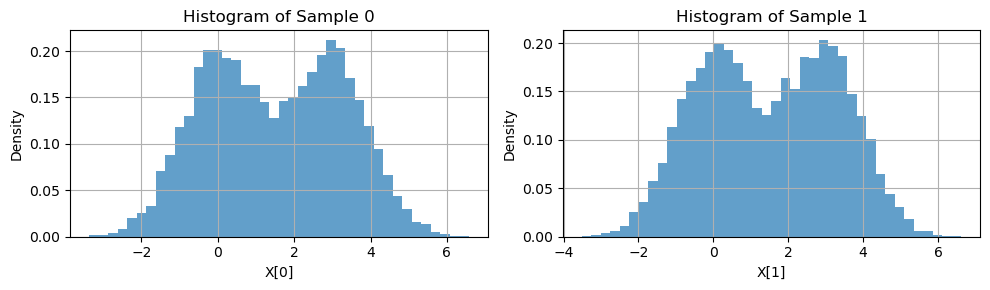

In [97]:
import torch
import matplotlib.pyplot as plt

def simple_gmm_sample(N, pi=0.5, mu1=[0, 0], mu2=[3, 3], sigma1=1.0, sigma2=1.0, device='cpu'):

    mu1 = torch.tensor(mu1, device=device)
    mu2 = torch.tensor(mu2, device=device)

    mix_indicator = torch.rand(N, device=device) < pi

    eps = torch.randn(N, 2, device=device)

    samples = torch.where(
        mix_indicator.unsqueeze(1),
        mu1 + sigma1 * eps,
        mu2 + sigma2 * eps
    )
    return samples

samples = simple_gmm_sample(N=10000, mu1=[0, 0], mu2=[3, 3], sigma1=1.0, sigma2=1.0)
samples_np = samples.cpu().numpy()

plt.figure(figsize=(10, 3))

for i in range(2): 
    plt.subplot(1, 2, i+1)
    plt.hist(samples_np[:, i], bins=40, density=True, alpha=0.7)
    plt.title(f"Histogram of Sample {i}")
    plt.xlabel(f"X[{i}]")
    plt.ylabel("Density")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
def generate_gmm_data(sample_fn, n_samples, T=6.0, device='cpu'):
    x0 = sample_fn(n_samples).to(device)
    t = torch.rand(n_samples, 1, device=device) * T
    m_t = torch.exp(-t)
    z = torch.randn(n_samples, 2, device=device)
    xt = m_t * x0 + torch.sqrt(1 - m_t**2) * z
    return x0, t, z, xt

In [8]:
device = "cpu"

In [10]:
class ScoreNet(nn.Module):
    def __init__(self, d=2, N=128, activation='relu'):
        super().__init__()
        self.N = N
        self.d = d
        self.input_dim = d + 1

        self.w = nn.Parameter(torch.randn(N, self.input_dim))
        self.b = nn.Parameter(torch.randn(N))
        self.a = nn.Parameter(torch.randn(N, d))

        if activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unknown activation")

    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_input = torch.cat([x, t], dim=1)

        B = x_input.shape[0]

        x_exp = x_input.unsqueeze(1)
        w_exp = self.w.unsqueeze(0)
        b_exp = self.b.unsqueeze(0).unsqueeze(-1)
        a_exp = self.a.unsqueeze(0)

        inner = torch.sum(w_exp * x_exp, dim=-1, keepdim=True)
        h = self.activation(inner + b_exp)
        contrib = h * a_exp

        return contrib.mean(dim=1)

In [11]:
import torch.nn as nn

class ScoreNet(nn.Module):
    def __init__(self, d=2, hidden_dim=128):
        super().__init__()
        input_dim = d + 1

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )


    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_in = torch.cat([x, t], dim=1)
        return self.net(x_in)

In [13]:
def compute_H(net, x0, t, z):
    B, d = x0.shape
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    kappa_t = sigma_t ** 2
    x_t = m_t * x0 + sigma_t * z
    x_t.requires_grad_(True)

    s = net(t, x_t)

    total_grad = [torch.zeros_like(p) for p in net.parameters()]

    for i in range(B):
        x_i = x_t[i].view(1, -1).clone().detach().requires_grad_(True)
        t_i = t[i].view(1, 1)
        z_i = z[i]

        s_i = net(t_i, x_i)[0]

        sigma_inv_z = z_i / sigma_t[i]
        coeff = sigma_inv_z + s_i

        for j in range(d):
            grad_sij = torch.autograd.grad(
                outputs=s_i[j],
                inputs=list(net.parameters()),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )

            for k in range(len(total_grad)):
                if grad_sij[k] is not None:
                    total_grad[k] += 2 * kappa_t[i, 0] * coeff[j] * grad_sij[k]

    return total_grad

In [15]:
def sgld_update(params, grads, lr, beta):
    updated = []
    for p, g in zip(params, grads):
        noise = torch.randn_like(p)
        noise_scale = (2 * lr / beta) ** 0.5
        p_new = p - lr * g + noise_scale * noise
        updated.append(p_new)
    return updated

In [16]:
net = ScoreNet()
net.train()

ScoreNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [17]:
from functools import partial

sample_fn = partial(simple_gmm_sample, 
                    pi=0.5,
                    mu1=[0, 0],
                    mu2=[3, 3],
                    sigma1=1.0,
                    sigma2=1.0,
                    device=device)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ScoreNet(d=2).to(device)
B, d = 64, 2
lr = 1e-3
beta = 10**8
num_steps = 30000
grad_norms = []
theta_trajectory = []

In [19]:
best_H = float('inf')
theta_hat_best = None

for step in range(num_steps):
    x0, t, z, xt = generate_gmm_data(sample_fn, n_samples=B, device=device)
    grads = compute_H(net, x0, t, z)
    grad_norm = torch.sqrt(sum(g.norm()**2 for g in grads if g is not None))
    grad_norms.append(grad_norm.item())
    updated_params = sgld_update(list(net.parameters()), grads, lr, beta)

    with torch.no_grad():
        for p, new_p in zip(net.parameters(), updated_params):
            p.copy_(new_p)

        H_value = sum((g**2).sum().item() for g in grads if g is not None)

        if H_value < best_H:
            best_H = H_value
            theta_hat_best = {
                name: p.detach().clone().cpu()
                for name, p in net.named_parameters()
            }


        theta = torch.cat([p.flatten() for p in net.parameters()])
        theta_trajectory.append(theta.cpu().numpy())

In [20]:
for name, p in net.named_parameters():
    print(name, torch.norm(p).item())

net.0.weight 6.162117958068848
net.0.bias 4.17299747467041
net.2.weight 7.388264179229736
net.2.bias 0.8601213693618774
net.4.weight 6.977168083190918
net.4.bias 0.8659413456916809
net.6.weight 1.6956959962844849
net.6.bias 0.03518209233880043


In [21]:
with torch.no_grad():
    for name, p in net.named_parameters():
        p.copy_(theta_hat_best[name].to(p.device))

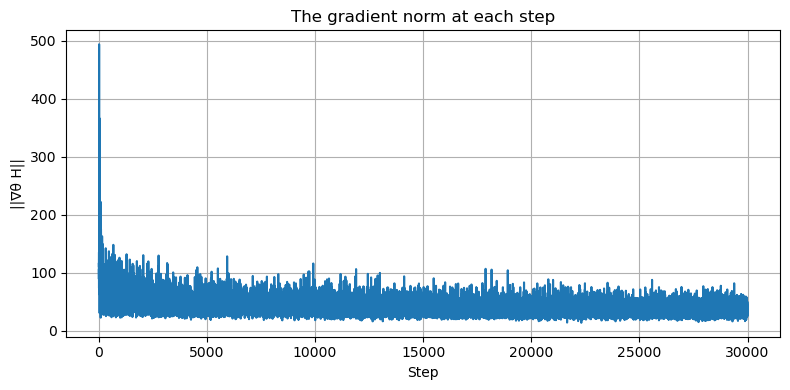

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(grad_norms)
plt.title("The gradient norm at each step")
plt.xlabel("Step")
plt.ylabel("||∇θ H||")
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

N_samples = 30000
dim = 2
K = 100000
T = 6.0
gamma = T/K
timesteps = np.linspace(0, T, K + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x0 = sample_fn(N_samples).to(device)
t_T = torch.full((N_samples, 1), T, device=device)
m_T = torch.exp(-t_T)
sigma_T = torch.sqrt(1 - torch.exp(-2 * t_T))
z = torch.randn_like(x0)
x_T = m_T * x0 + sigma_T * z
Y = x_T.clone()
for k in tqdm(range(K)):
    t_k = timesteps[k]
    tau = torch.full((N_samples, 1), T - t_k, device=device)

    with torch.no_grad():
        s_val = net(tau, Y)

    drift = Y + 2 * s_val
    noise = torch.randn_like(Y)
    Y = Y + gamma * drift + torch.sqrt(torch.tensor(2 * gamma)) * noise

samples = Y.cpu().numpy()

100%|██████████████████████████████████| 100000/100000 [10:58<00:00, 151.95it/s]


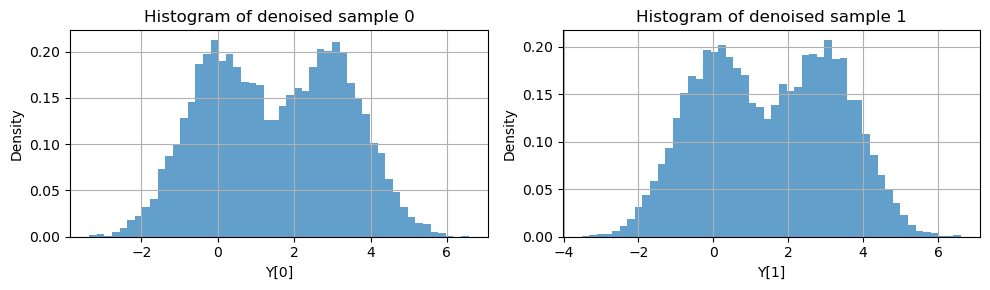

In [98]:
plt.figure(figsize=(10, 3))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.7)
    plt.title(f"Histogram of denoised sample {i}")
    plt.xlabel(f"Y[{i}]")
    plt.ylabel("Density")
    plt.grid(True)

plt.tight_layout()
plt.show()
